In [147]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import scipy.stats as stats
import math

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import random


In [126]:
data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

In [3]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [15]:
data['holiday'].unique()

array([nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [18]:
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weekday,hour,isholiday
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.0
mean,281.205870,0.334264,0.000222,49.362231,3259.818355,2.984980,11.398162,0.0
std,13.338232,44.789133,0.008168,39.015750,1986.860670,2.005941,6.940238,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,272.160000,0.000000,0.000000,1.000000,1193.000000,1.000000,5.000000,0.0
50%,282.450000,0.000000,0.000000,64.000000,3380.000000,3.000000,11.000000,0.0
75%,291.806000,0.000000,0.000000,90.000000,4933.000000,5.000000,17.000000,0.0
max,310.070000,9831.300000,0.510000,100.000000,7280.000000,6.000000,23.000000,0.0


# Feature Engineering 

In [127]:
data['year'] = data['date_time'].apply(lambda x: x[:4])
data['month'] = data['date_time'].apply(lambda x: x[5:7])
data['weekday'] = pd.to_datetime(data['date_time']).apply(lambda x: x.weekday())
data['hour'] = pd.to_datetime(data['date_time']).apply(lambda x: x.hour)
data['isholiday'] = (data['holiday'] == 'None').apply(float)

In [11]:
X = data[['year','month', 'weekday', 'hour', 'isholiday']]
y = data['traffic_volume']

In [47]:
print(y)


[5545 4516 4767 ... 2159 1450  954]


### MinMax Scaling 

In [79]:

scaler = MinMaxScaler()
y_scale = scaler.fit_transform(y.reshape(-1, 1))


### Split dataset

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, random_state=49, shuffle=False)

# knn

In [86]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(r2_score(list(y_test), list(y_pred)))

0.9109062511557937


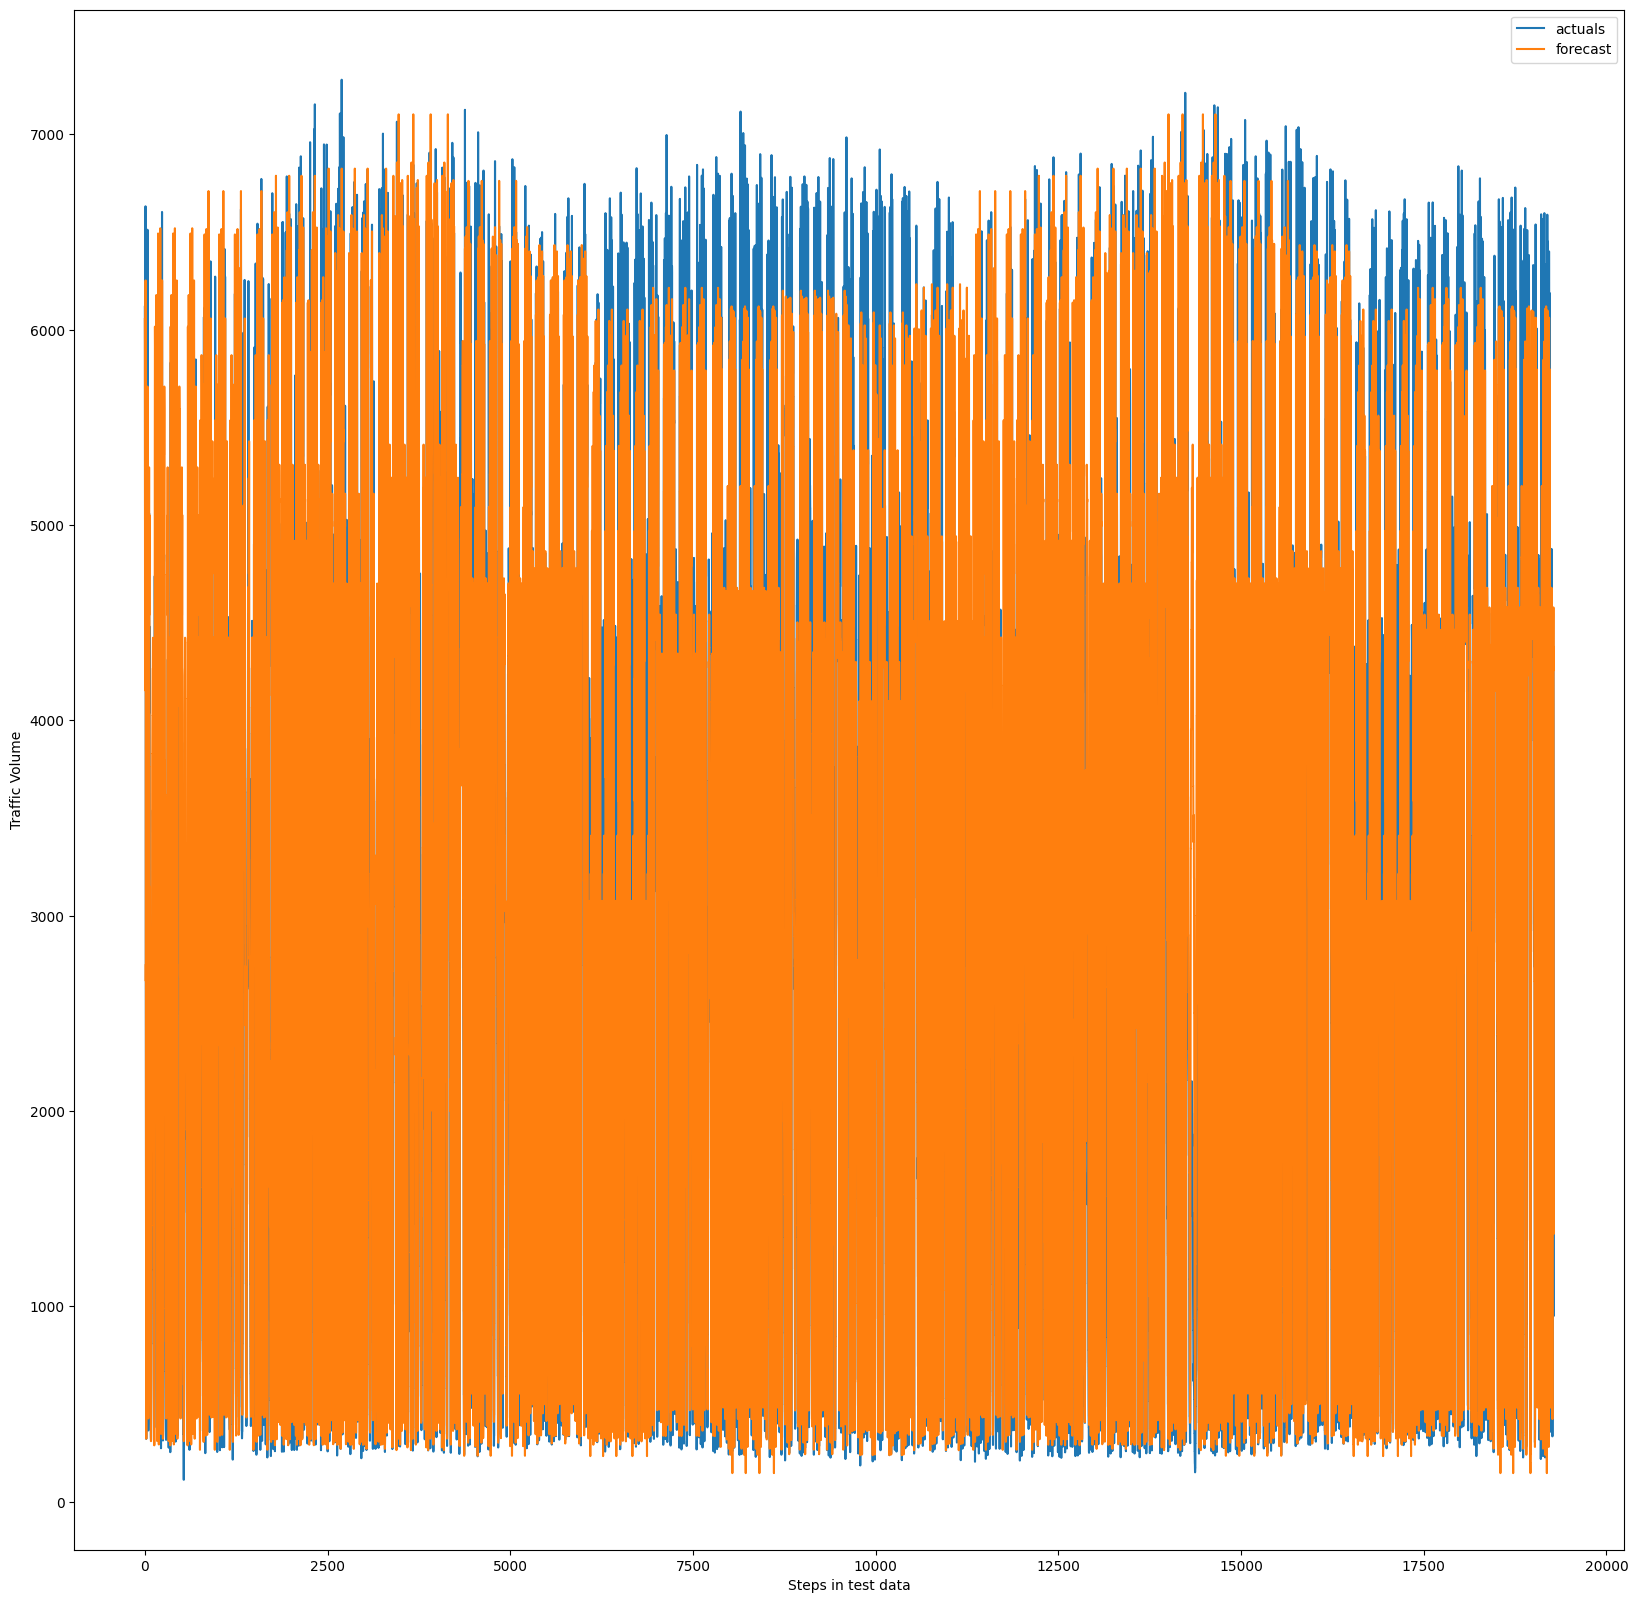

In [87]:
plt.figure(figsize=(20,20))
plt.plot(list(y_test))
plt.plot(list(y_pred))
plt.legend(['actuals', 'forecast'])
plt.ylabel('Traffic Volume')
plt.xlabel('Steps in test data')
plt.show()

### Optimizing KNN with GridSearchCV and RandomSearchCV

In [88]:

knn_rs = RandomizedSearchCV(KNeighborsRegressor(), 
                 {'n_neighbors':list(range(1, 30))},
                scoring = 'r2', n_iter=10, n_jobs = -1)

knn_rs.fit(X_train, y_train)
print(r2_score(list(y_test), list(knn_rs.predict(X_test))))
print(knn_rs.best_estimator_)

0.9186348251750062
KNeighborsRegressor(n_neighbors=27)


In [89]:
knn_grid = GridSearchCV(KNeighborsRegressor(), 
                 {'n_neighbors':list(range(1, 60))},
                scoring = 'r2', n_jobs = -1)

knn_grid.fit(X_train, y_train)
print(r2_score(list(y_test), list(knn_grid.predict(X_test))))
print(knn_grid.best_estimator_)


0.9188034132294687
KNeighborsRegressor(n_neighbors=24)


## Evaluation 

In [105]:
mse = mean_squared_error(list(y_test), list(y_pred))
rmse = sqrt(mse)
print("rmse is:", rmse ,"and mse is:", mse)

rmse is: 589.7597784614013 and mse is: 347816.5962908412


# Random Forest

In [72]:
import warnings
warnings.filterwarnings("ignore")

In [90]:
model1 = RandomForestRegressor()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(r2_score(list(y_test), list(y_pred1)))

0.9142846332230301


## Grid Search for Random Forest

In [101]:


my_rf = GridSearchCV(RandomForestRegressor(), 
                 {'max_features':[0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
                 'n_estimators': [10, 50, 100, 250, 500, 750, 1000]},
                scoring = 'r2', n_jobs = -1)

my_rf.fit(X_train, y_train)
print(r2_score(list(y_test), list(my_rf.predict(X_test))))
print(my_rf.best_params_)

0.9141755912287085
{'max_features': 0.7, 'n_estimators': 250}


In [102]:
distributions = {
    'max_features': [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'n_estimators': stats.randint(50, 1000)
}

# Creating the search
my_rf = RandomizedSearchCV(RandomForestRegressor(),
                           
                     distributions, n_iter=10,
                          scoring = 'r2',
                          n_jobs = -1,
                          random_state = 12345)

# Fitting the search
my_rf.fit(X_train, y_train)

# Printing the results
print(r2_score(list(y_test), list(my_rf.predict(X_test))))
print(my_rf.best_params_)

0.9139234255591874
{'max_features': 0.7, 'n_estimators': 141}


In [103]:
fi = pd.DataFrame({
        'feature': X_train.columns,
        'importance': my_rf.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)

,feature,importance
3,hour,0.878316
2,weekday,0.092128
1,month,0.019777
0,year,0.009779
4,isholiday,0.000000


# XGBoost model

In [134]:
# Create objects X and y
X = data[['year', 'month', 'weekday', 'hour', 'isholiday']]
y = data['traffic_volume']

# Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=12345, shuffle=False)

from xgboost import XGBRegressor
my_xgb = XGBRegressor()
my_xgb.fit(X_train, y_train)

xgb_fcst = my_xgb.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(list(y_test), list(xgb_fcst)))

0.9726292617325978


In [135]:
my_lgbm = LGBMRegressor()
my_lgbm.fit(X_train, y_train)

lgbm_fcst = my_lgbm.predict(X_test)

print(r2_score(list(y_test), list(lgbm_fcst)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 48104, number of used features: 4
[LightGBM] [Info] Start training from score 3259.693685
0.9728060730071293


In [51]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
xgb_pred = model_xgb.predict(X_test)

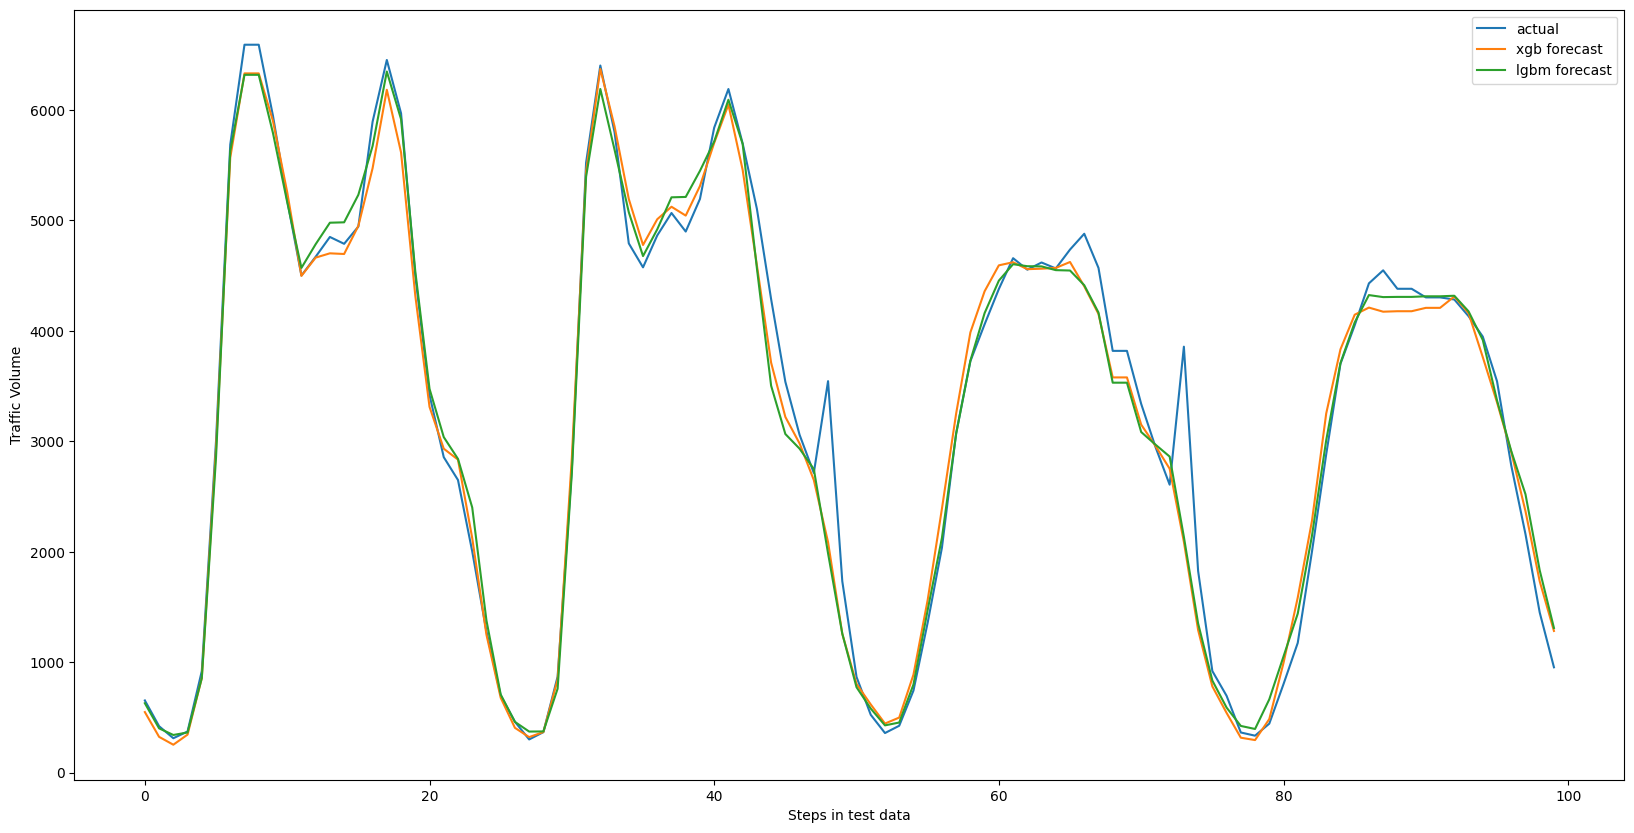

In [136]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(list(y_test))
plt.plot(list(xgb_fcst))
plt.plot(list(lgbm_fcst))
plt.legend(['actual', 'xgb forecast', 'lgbm forecast'])
plt.ylabel('Traffic Volume')
plt.xlabel('Steps in test data')
plt.show()

In [ ]:

random.seed(0)

xgb_opt = BayesSearchCV(
    XGBRegressor(),
    {
        'learning_rate': (10e-6, 1.0, 'log-uniform'),
        'max_depth': Integer(0, 50, 'uniform'),
        'n_estimators' : (10, 1000, 'log-uniform'),
    },
    n_iter=10,
    cv=3
)


xgb_opt.fit(X_train, y_train)
xgb_tuned_fcst = opt.best_estimator_.predict(X_test)

In [ ]:
random.seed(0)
lgbm_opt = BayesSearchCV(
    LGBMRegressor(),
    {
        'learning_rate': (10e-6, 1.0, 'log-uniform'),
        'max_depth': Integer(-1, 50, 'uniform'),
        'n_estimators' : (10, 1000, 'log-uniform'),
    },
    n_iter=10,
    cv=3
)

lgbm_opt.fit(X_train, y_train)

lgbm_tuned_fcst = lgbm_opt.best_estimator_.predict(X_test)
r2_score(list(y_test), list(lgbm_tuned_fcst))